# Implémentation en diverses étapes de l'algorithme deepDTnet

In [115]:
import numpy as np
import torch
import torch.autograd
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from scipy.optimize import minimize
import random

import matplotlib.pyplot as plt

### Computing co-occurence matrices (PCO) with random surfing with return

In [2]:
def normalize(M):
    #Put diagonal elements to 0
    M  = M - np.diag(np.diag(M))
    
    #Normalizing by row
    D_inv = np.diag(np.reciprocal(np.sum(M,axis=0)))
    M = np.dot(D_inv,  M)

    return M

In [19]:
def PCO(A, K, alpha):
    """
    For a graph represented by its adjacency matrix *A*, computes the co-occurence matrix by random 
    surfing on the graph with returns. 1-alpha is the probability to make, at each step, a return 
    to the original step.
    """
    A=np.array(A, dtype=float)
    
    #The adjacency matrix A is first normalized
    A=normalize(A) 
    
    n=A.shape[0]
    
    I=np.eye(n)
    
    P=I
    M=np.zeros((n, n))
    
    for i in range(K):
        P = alpha*np.dot(P,A) + (1-alpha)*I
        M = M+P
    
    return(M)

In [4]:
PCO([[0,1,1],[1,0,1],[1,1,0]], 4, 0.6)

[[0.  0.5 0.5]
 [0.5 0.  0.5]
 [0.5 0.5 0. ]]
[[0.4 0.3 0.3]
 [0.3 0.4 0.3]
 [0.3 0.3 0.4]]
[[0.58 0.21 0.21]
 [0.21 0.58 0.21]
 [0.21 0.21 0.58]]
[[0.526 0.237 0.237]
 [0.237 0.526 0.237]
 [0.237 0.237 0.526]]
[[0.5422 0.2289 0.2289]
 [0.2289 0.5422 0.2289]
 [0.2289 0.2289 0.5422]]


array([[2.0482, 0.9759, 0.9759],
       [0.9759, 2.0482, 0.9759],
       [0.9759, 0.9759, 2.0482]])

### From co-occurence matrices (PCO) to shifted positive pointwise mutual information (PPMI) 

In [5]:
def PPMI(M):
    """Computes the shifted positive pointwise mutual information (PPMI) matrix
    from the co-occurence matrix (PCO) of a graph."""
    
    M=normalize(M)
    cols = np.sum(M, axis=0)
    rows = np.sum(M, axis=1).reshape((-1,1))
    s = np.sum(rows)
    
    P = s*M
    P /= cols
    P /= rows
    
    #P[np.where(P<0)] = 1.0
    P = np.log(P)

    #To avoid NaN when applying log
    P[np.isnan(P)] = 0.0
    P[np.isinf(P)] = 0.0
    P[np.isneginf(P)] = 0.0
    P[np.where(P<0)] = 0.0
    
    return(P)

In [6]:
PPMI(PCO([[0,1,1],[1,0,1],[1,1,0]], 4, 0.4))

[[0.  0.5 0.5]
 [0.5 0.  0.5]
 [0.5 0.5 0. ]]
[[0.6 0.2 0.2]
 [0.2 0.6 0.2]
 [0.2 0.2 0.6]]
[[0.68 0.16 0.16]
 [0.16 0.68 0.16]
 [0.16 0.16 0.68]]
[[0.664 0.168 0.168]
 [0.168 0.664 0.168]
 [0.168 0.168 0.664]]
[[0.6672 0.1664 0.1664]
 [0.1664 0.6672 0.1664]
 [0.1664 0.1664 0.6672]]


/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


array([[0.        , 0.40546511, 0.40546511],
       [0.40546511, 0.        , 0.40546511],
       [0.40546511, 0.40546511, 0.        ]])

### Embedding with stacked denoising autoencoders (SDAE)

In [103]:
class GaussianNoise(nn.Module):
    def __init__(self, stddev):
        super().__init__()
        self.stddev = stddev

    def forward(self, din):
        if self.training:
            return din + torch.randn(din.size()) * self.stddev
        return din

In [348]:
class DropoutNoise(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p
    
    def forward(self, x):
        self.size = tuple(x.size())
        
        a = np.random.random(self.size) > self.p
        a = np.array(a, dtype=float)
        
        return(x*a)

In [350]:
x = torch.Tensor([[1,2,3],[4,5,6],[7,8,9]])
DropoutNoise(0.9)(x)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)

In [351]:
class BasicBlock(nn.Module):
    def __init__(self, input_shape, n_neurons, activation='relu', noise=None, noise_arg=None):
        super().__init__()
        self.n_neurons = n_neurons
        self.input_shape = input_shape
        
        self.has_noise = False
        
        if noise=='gaussian':
            self.has_noise = True
            self.noise = GaussianNoise(noise_arg)
        elif noise=='dropout':
            self.has_noise = True
            self.noise = DropoutNoise(noise_arg)
            
        self.dense_layer = nn.Linear(self.input_shape, self.n_neurons)
        
        activations_map = {'relu':nn.ReLU, 'tanh':nn.Tanh, 'sigmoid':nn.Sigmoid}
        self.activation = activations_map[activation]()

    def forward(self, features):
        x=features
        
        if self.has_noise:
            x = self.noise(x)

        x = self.dense_layer(features)
        x = self.activation(x)
        
        return(x)

In [364]:
class SDAE(nn.Module):
    def __init__(self, input_shape, hidden_layers, activation='relu', last_activation='relu', noise_type='dropout', noise_arg=0.2):
        super().__init__()
        self.inputs = [input_shape] + hidden_layers
        
        n = len(self.inputs)
        encoder_units = [BasicBlock(self.inputs[0], self.inputs[1], activation=activation, noise=noise_type, noise_arg=noise_arg)]
        encoder_units.extend([BasicBlock(self.inputs[i], self.inputs[i+1], activation=activation) for i in range(1, n-1)])
        
        self.encoder = nn.Sequential(*encoder_units)
        
        decoder_units = [BasicBlock(self.inputs[i], self.inputs[i-1], activation=activation) for i in range(n-1,1,-1)]
        decoder_units.append(BasicBlock(self.inputs[1], self.inputs[0], activation=last_activation))
        
        self.decoder = nn.Sequential(*decoder_units)
        
    def forward(self, features):
        encoded = self.encoder(features)
        
        decoded = self.decoder(encoded)
        
        return(decoded)

#### Testing the SDAE on MNIST

In [10]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SDAE(784, [372, 186, 93]).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

In [11]:
summary(model, (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 372]         292,020
              ReLU-2                  [-1, 372]               0
     GaussianNoise-3                  [-1, 372]               0
        BasicBlock-4                  [-1, 372]               0
            Linear-5                  [-1, 186]          69,378
              ReLU-6                  [-1, 186]               0
     GaussianNoise-7                  [-1, 186]               0
        BasicBlock-8                  [-1, 186]               0
            Linear-9                   [-1, 93]          17,391
             ReLU-10                   [-1, 93]               0
    GaussianNoise-11                   [-1, 93]               0
       BasicBlock-12                   [-1, 93]               0
           Linear-13                  [-1, 186]          17,484
             ReLU-14                  [

In [100]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)

testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

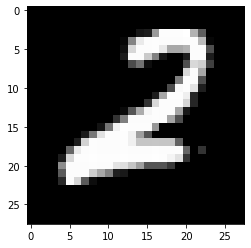

In [101]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img     # unnormalize
    #npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels

In [102]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs=torch.flatten(inputs)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.059
[1,  4000] loss: 0.044
[1,  6000] loss: 0.038
[1,  8000] loss: 0.035
[1, 10000] loss: 0.034
[1, 12000] loss: 0.033
[1, 14000] loss: 0.031
[1, 16000] loss: 0.031
[1, 18000] loss: 0.030
[1, 20000] loss: 0.028
[1, 22000] loss: 0.029
[1, 24000] loss: 0.028
[1, 26000] loss: 0.028
[1, 28000] loss: 0.027
[1, 30000] loss: 0.027
[1, 32000] loss: 0.026
[1, 34000] loss: 0.026
[1, 36000] loss: 0.026
[1, 38000] loss: 0.026
[1, 40000] loss: 0.026
[1, 42000] loss: 0.025
[1, 44000] loss: 0.025
[1, 46000] loss: 0.025
[1, 48000] loss: 0.024
[1, 50000] loss: 0.025
[1, 52000] loss: 0.024
[1, 54000] loss: 0.024
[1, 56000] loss: 0.024
[1, 58000] loss: 0.024
[1, 60000] loss: 0.024
Finished Training


torch.Size([1, 1, 28, 28])


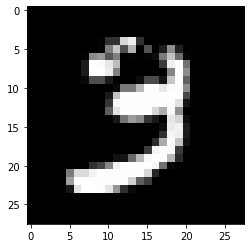

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


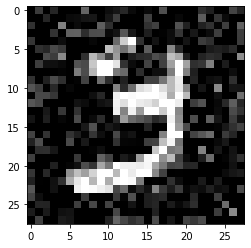

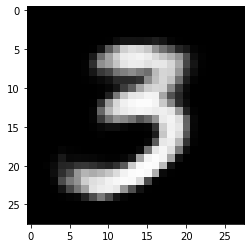

In [108]:
for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    print(inputs.shape)
    imshow(torchvision.utils.make_grid(inputs).numpy())     
    
    inputs=torch.flatten(inputs)
        # zero the parameter gradients
        # forward + backward + optimize
    
    inputs_noise=GaussianNoise(0.2)(inputs).reshape((1,1,28,28))
    imshow(torchvision.utils.make_grid(inputs_noise).detach().numpy())
    
    outputs = model(inputs).reshape((1, 1, 28, 28))
    
    imshow(torchvision.utils.make_grid(outputs).detach().numpy())     
    break

### PU-Learning via matrix completion and convex optimization

In [114]:
#PU Learning

k = 7
Fd = 20
Ft = 20

#Number of variables
N_variables = Fd * k + Ft * k

#Because scipy's minimize needs a (n,) array of variables
mat_compo = {}
compo_mat = []
p=0

for c in ['H', 'W']:
    for i in range(Fd if c=='H' else Ft):
        for j in range(k):
            mat_compo[(c, i, j)] = p
            compo_mat.append((c, i, j))
            p += 1

In [117]:
Nd = 20
Nt = 20

p = np.eye(20, dtype=float)
x = np.random.randn(Nd,Fd)
y = np.random.randn(Nt,Ft)

alpha = 0.2
gamma = 0.3

Ipos = [(i,i) for i in range(min(Nd,Nt))]
Ineg = [(i,j) for i in range(Nd) for j in range(Nt) if (i,j) not in Ipos]
I = Ipos + Ineg

def objective(z):
    res=0
    
    H = np.zeros((Fd,k), dtype=float)
    W = np.zeros((Ft,k), dtype=float)
    
    for i in range(Fd):
        for j in range(k):
            H[i,j]=z[mat_compo[('H', i, j)]]
            
    for i in range(Ft):
        for j in range(k):
            W[i,j]=z[mat_compo[('W', i, j)]]
         
    for (i,j) in Ipos:
        res += (p[i,j]- np.dot(np.dot(x[i,:], (H @ np.transpose(W))), y[:,j]))**2
    for (i,j) in Ineg:
        res += alpha*(p[i,j]- np.dot(np.dot(x[i,:], (H @ np.transpose(W))), y[:,j]))**2
    
    Sreg = gamma/2 * (np.linalg.norm(H) + np.linalg.norm(W))
    
    res += Sreg
    
    return(res)

In [123]:
res = minimize(objective,x0 = np.random.randn(N_variables), options={'maxiter':1000, 'disp':'True'})

         Current function value: 6.829665
         Iterations: 1000
         Function evaluations: 284538
         Gradient evaluations: 1009


In [128]:
z=res['x']
H = np.zeros((Fd,k), dtype=float)
W = np.zeros((Ft,k), dtype=float)
    
for i in range(Fd):
    for j in range(k):
        H[i,j]=z[mat_compo[('H', i, j)]]
            
for i in range(Ft):
    for j in range(k):
        W[i,j]=z[mat_compo[('W', i, j)]]

H @ np.transpose(W)

for i,j in Ineg:
    print(np.dot(np.dot(x[i,:], (H @ np.transpose(W))), y[:,j]))

0.2156256971064746
0.32101247399922694
-0.08885838184022438
0.08233132094469015
0.062120094941989355
-0.3769398966190506
-0.16007070675968857
-0.1175141503312301
0.3132671197931596
0.12212999909888365
0.18886774771029252
0.1406524958251719
0.34237874607068397
-0.2840154424597365
0.04800438015653148
-0.11207551752224493
0.03384893586862922
0.27059663352276064
-0.48687662827390343
0.19229498628662084
-0.2630780666249034
0.11850204407581913
0.1061514311398693
-0.1488636535906391
0.2101892946283354
-0.08611401275830777
0.3248914544289978
0.22064895828783526
-0.21372587896585798
0.28920854715348643
0.2303915437191929
0.43439703814341285
-0.1169274019061948
0.3577067468410794
0.18783391568892388
0.045509432547769624
-0.2095365695838818
-0.14464879335870995
0.32321428325492335
-0.24325847533612158
-0.1266791676258012
0.4080895645803141
0.039041491129598496
0.009295704832545992
-0.34240381593296176
-0.059335308473098064
-0.042737677874143565
0.2350307312628195
0.020343417516329065
0.0874102056

### Generate random networks

In [232]:
def random_graph(p, size=(100,100)):
    return(np.array([[int(random.random() < p) for i in range(size[1])] for j in range(size[0])]))

def random_undirected_graph(p, size=(100,100)):
    graph = random_graph(p, size=size)
    graph[np.arange(size[0]),np.arange(size[1])]=0 #nullify the diagonal
    graph = np.maximum(graph, graph.T) #make it symmetric
    
    return(graph)

In [255]:
def random_graph_with_fixed_components(p, nodes_per_component=[50,50]):
    nodes_per_component = np.array(nodes_per_component)
    n_nodes = nodes_per_component.sum()
    n_cmp = nodes_per_component.shape[0]
    
    graph = np.zeros((n_nodes, n_nodes))
    nodes = np.arange(n_nodes)
    np.random.shuffle(nodes)
    
    cmp_nodes = []
    acc=0
    
    for i in range(n_cmp):
        cmp = nodes[acc:(acc+nodes_per_component[i])]
        cmp_nodes.append(cmp)
        acc += nodes_per_component[i]
        
        size = cmp.shape[0]
        submatrix=np.ix_(cmp,cmp)

        graph[submatrix] = random_undirected_graph(p, (size,size))
        
    return(graph)

In [362]:
def neighbors(adj, i):
    return (np.where(adj[i,:]==1)[0])

def dfs(adj, i):
    n = adj.shape[0] #number of nodes in the graph
    visited = [False for k in range(n)]
    
    stack = [i]
    
    while(len(stack)>0):
        k = stack.pop()
        neighborhood = neighbors(adj, k)
        visited[k] = True
        
        for n in neighborhood:
            if not visited[n]:
                stack.append(n)
    
    return(np.where(visited))

def connected_components(adj):
    n = adj.shape[0]
    
    visited = np.array([0 for k in range(n)])
    s = np.sum(visited)
    
    comp=[]
    
    while s<n:
        i = np.where(1-visited)[0][0]
        
        cmp = dfs(adj, i)
        visited[cmp] = 1
        s = np.sum(visited)
        
        comp.append(list(cmp[0]))
    
    return(np.array(comp))

In [279]:
N_rand_drugs = 784
N_rand_targets = 1000

density=0.5
#generate random matrices in M({0,1})
#1. a drug-drug network (drug similarities)
#2. a protein-protein network (protein similarities)
#3. a drug-protein network (drug-target known relationships)
dd_net = random_graph_with_fixed_components(density, [196,196,196,196])
pp_net = random_graph_with_fixed_components(density, [100 for i in range(10)])
dp_net = random_graph(density,size=(N_rand_drugs,N_rand_targets))

np.sum(dp_net)/(N_rand_drugs*N_rand_targets)

0.5001339285714286

In [280]:
np.sum(np.sum(dd_net))/(dd_net[0].shape[0])**2

0.18621147438567265

In [281]:
dd_net[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0.

### Encoding the drug-drug network

In [321]:
K = 10
alpha = 0.2

ppmi_dd_net = PPMI(PCO(dd_net, K, alpha))

ppmi_dd_net.shape

/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


(784, 784)

In [366]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SDAE(784, [500, 200, 100], activation='sigmoid', last_activation='sigmoid').to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

In [367]:
summary(model, (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
      DropoutNoise-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
           Sigmoid-3                  [-1, 500]               0
        BasicBlock-4                  [-1, 500]               0
            Linear-5                  [-1, 200]         100,200
           Sigmoid-6                  [-1, 200]               0
        BasicBlock-7                  [-1, 200]               0
            Linear-8                  [-1, 100]          20,100
           Sigmoid-9                  [-1, 100]               0
       BasicBlock-10                  [-1, 100]               0
           Linear-11                  [-1, 200]          20,200
          Sigmoid-12                  [-1, 200]               0
       BasicBlock-13                  [-1, 200]               0
           Linear-14                  [

In [368]:
#ppmi_dd_net = (ppmi_dd_net - ppmi_dd_net.mean(axis=0)) / (ppmi_dd_net.std(axis=0))
ppmi_dd_net[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.60408146, 0.        , 0.        ,
       0.        , 1.56300076, 0.        , 0.        , 1.58436426,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.58634296, 1.59339621, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.5592621 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.61541055, 0.        , 1.62067346, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.61363193, 0.        , 1.57987602, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.56780089, 0.        , 1.56404455, 1.67590289, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [369]:
train = torch.utils.data.TensorDataset(torch.Tensor(ppmi_dd_net), torch.Tensor(ppmi_dd_net))
train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)

In [370]:
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs=torch.flatten(inputs)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 784 == 783: 
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 784))
            running_loss = 0.0

print('Finished Training')

[1,   784] loss: 0.481
[2,   784] loss: 0.461
[3,   784] loss: 0.452
[4,   784] loss: 0.448
[5,   784] loss: 0.447
[6,   784] loss: 0.446
[7,   784] loss: 0.444
[8,   784] loss: 0.443
[9,   784] loss: 0.442
[10,   784] loss: 0.441
[11,   784] loss: 0.441
[12,   784] loss: 0.440
[13,   784] loss: 0.440
[14,   784] loss: 0.440
[15,   784] loss: 0.439
[16,   784] loss: 0.439
[17,   784] loss: 0.439
[18,   784] loss: 0.438
[19,   784] loss: 0.438
[20,   784] loss: 0.438
[21,   784] loss: 0.437
[22,   784] loss: 0.437
[23,   784] loss: 0.437
[24,   784] loss: 0.436
[25,   784] loss: 0.436
[26,   784] loss: 0.435
[27,   784] loss: 0.435
[28,   784] loss: 0.435
[29,   784] loss: 0.435
[30,   784] loss: 0.435
[31,   784] loss: 0.435
[32,   784] loss: 0.435
[33,   784] loss: 0.435
[34,   784] loss: 0.435
[35,   784] loss: 0.435
[36,   784] loss: 0.434
[37,   784] loss: 0.434
[38,   784] loss: 0.434
[39,   784] loss: 0.434
[40,   784] loss: 0.434
[41,   784] loss: 0.433
[42,   784] loss: 0.433
[

In [371]:
trainiter = iter(train_loader)
inputs, _ = trainiter.next()

print(inputs)
print(model(inputs))

from sklearn.metrics import mean_squared_error

print(mean_squared_error(inputs.detach().numpy(), model(inputs).detach().numpy()))

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.6041, 0.0000,
         0.0000, 0.0000, 1.5630, 0.0000, 0.0000, 1.5844, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.5863, 1.5934, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.5593, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.6154, 0.0000, 1.6207, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.6136, 0.0000, 1.5799, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.5678, 0.0000, 1.5640,
         1.6759, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.5665, 1.5818, 0.0000, 0.0000, 1.5637,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.5756, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.5550, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

### Connected components

In [240]:
graph = random_undirected_graph(0.02, size=(100, 100))
graph[0,:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [363]:
connected_components(random_graph_with_fixed_components(0.2, [25,25,25,25]))

array([[ 0,  1,  3,  6,  8, 16, 20, 21, 31, 32, 38, 39, 41, 45, 55, 56,
        60, 64, 65, 67, 68, 76, 81, 87, 95],
       [ 2,  9, 18, 24, 27, 34, 35, 40, 48, 52, 59, 71, 75, 77, 78, 79,
        80, 82, 83, 84, 85, 89, 93, 96, 97],
       [ 4,  5,  7, 10, 22, 23, 28, 29, 44, 46, 47, 53, 54, 58, 62, 63,
        66, 70, 73, 74, 86, 88, 90, 92, 99],
       [11, 12, 13, 14, 15, 17, 19, 25, 26, 30, 33, 36, 37, 42, 43, 49,
        50, 51, 57, 61, 69, 72, 91, 94, 98]])

### Embedding evaluation with t-SNE visualization

In [315]:
from sklearn.manifold import TSNE

def visualize_TSNE(embeddings,target):
    tsne = TSNE(n_components=2, init='pca',
                         random_state=0, perplexity=30)
    data = tsne.fit_transform(embeddings)
    #plt.figure(figsize=(12, 6))
    plt.title("TSNE visualization of the embeddings")
    plt.scatter(data[:,0],data[:,1],c=target)

    return

In [316]:
def get_embeddings(train_loader, N, model, size_encoded=100):
    trainiter = iter(train_loader)
    embeddings = np.zeros((N, size_encoded))

    for i,q in enumerate(trainiter):
        embedded = model.encoder(q[0]).detach().numpy()
        embeddings[i,:] = embedded.reshape((size_encoded,))
    
    return(embeddings)

In [372]:
embeddings=get_embeddings(train_loader, N_rand_drugs, model)

In [373]:
cmps = connected_components(dd_net)
targets = [0 for i in range(N_rand_drugs)]

for i, cmp in enumerate(cmps):
    for n in cmp:
        targets[n] = i

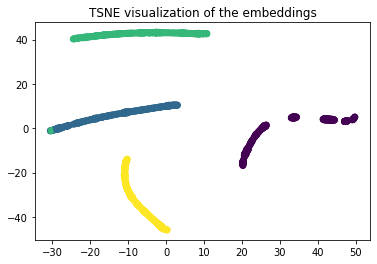

In [374]:
visualize_TSNE(embeddings, targets)

# [References]

[1] X. Zeng, S. Zhu, W. Lu, Z. Liu, J. Huang, Y. Zhou, J. Fang, Y. Huang, H. Guo, L. Li, B. D. Trapp, R. Nussinov, C. Eng, J. Loscalzo, F. Cheng, Target identification among known drugs by deep learning from heterogeneous networks. Chem. Sci.11, 1775–1797 (2020).

[2] Shaosheng Cao, Wei Lu, and Qiongkai Xu. 2016. Deep neural networks for learning graph representations. In Proceedings of the Thirtieth AAAI Conference on Artificial Intelligence (AAAI'16). AAAI Press, 1145–1152.